# Creating Multi-Zone Models Out of NuPyCEE

Prepared by: Benoit Côté (bcote@uvic.ca)

This notebook shows the basics of creating multi-zone models by combining several one-zone <a href="http://adsabs.harvard.edu/abs/2017ApJ...835..128C">OMEGA</a> models. OMEGA is part of the <a href="https://github.com/NuGrid/NuPyCEE">NuPyCEE</a> package.

Using the **`external_control=True`** option, it is possible to run an OMEGA simulation one step at a time, and specify the star formation rate at each timestep.  In addition, when passing the **`no_in_out=True`** argument when advancing OMEGA by one step, you can bypass the galactic inflow and outflow prescription to add and remove gas by hand. Using these capabilities, it is possible to connect different OMEGA simulations together, controlled by an external multi-zone code.

In [1]:
# Import python modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Import the OMEGA+ module
from NuPyCEE import omega

## 1. Running OMEGA Step-by-Step

In [2]:
# Run default OMEGA
o = omega.omega()

# Start OMEGA with external control
o_ext_1 = omega.omega(external_control=True)

OMEGA run in progress..
   OMEGA run completed - Run time: 0.34s
OMEGA run in progress..


As you can see, the default OMEGA instance ran completely, but the OMEGA instance with external controled has not.  It does not mean the code is still running, it simply halted and is now waiting for instructions.

#### Complete the simulation step by step

In [3]:
# For each timestep ..
for i_t in range(o.nb_timesteps):
    
    # Copy the star formation rate of the default OMEGA
    sfr = o.history.sfr_abs[i_t]
    
    # Run the halted OMEGA by one step, using the same
    # star formation rate as in the default mode.
    o_ext_1.run_step(i_t+1, sfr)

   OMEGA run completed - Run time: 2.76s


The OMEGA with external control has now finished.  Note that the run time is larger than usual.  This represents the delay between the creating of the OMEGA instance and the completion of the run.

#### Compare results

<IPython.core.display.Javascript object>


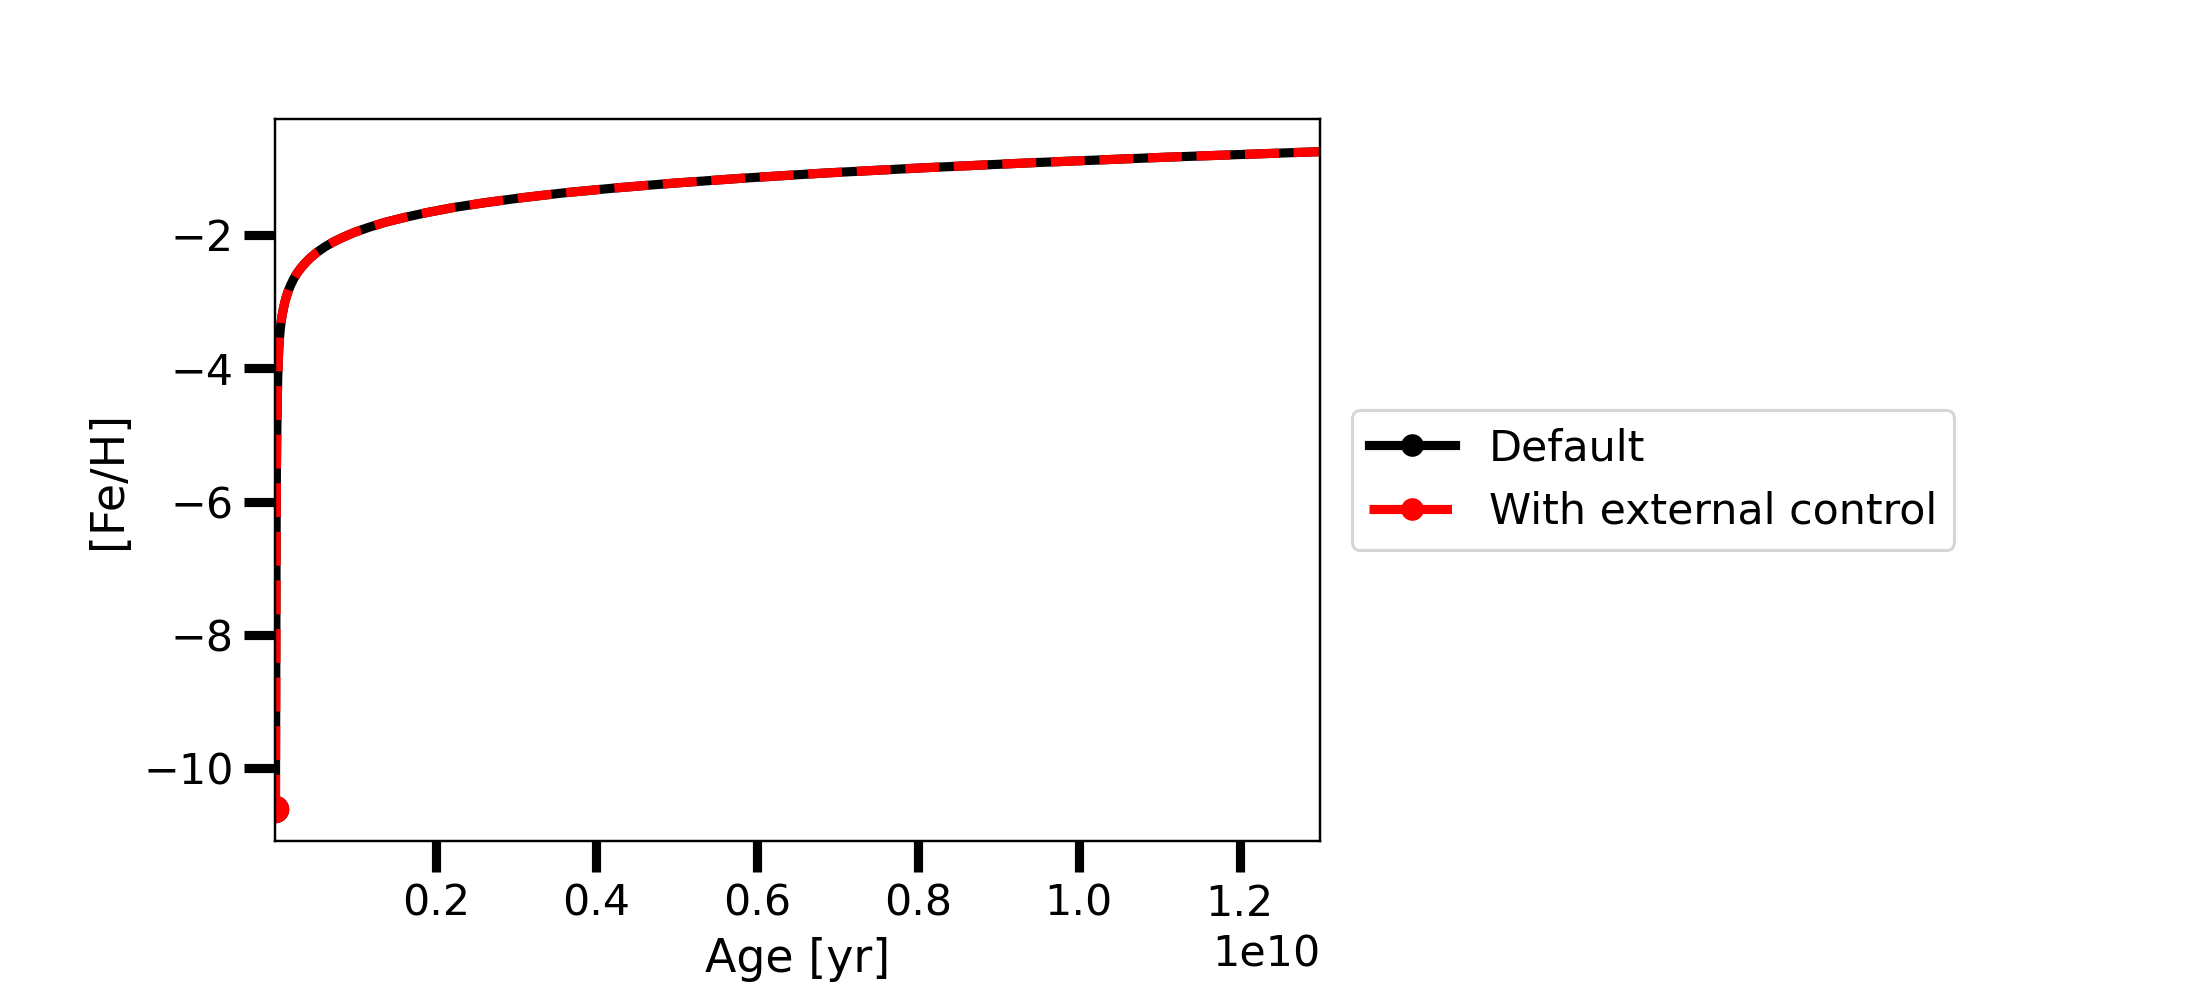

In [5]:
# Plot the evolution of [Fe/H] for the two OMEGAs, which should be the same
%matplotlib nbagg
o.plot_spectro(color='k', label='Default')
o_ext_1.plot_spectro(color='r', shape='--', label='With external control')

## 2. Modifying the Star Formation Rate by Hand

In [6]:
# Start OMEGA with external control
o_ext_2 = omega.omega(external_control=True)

# For each timestep ..
for i_t in range(o.nb_timesteps):
    
    # Copy the star formation rate of the default OMEGA
    sfr = o.history.sfr_abs[i_t]
    
    # Run the halted OMEGA by one step, but by modifying
    # the star formation rate compared to the default
    o_ext_2.run_step(i_t+1, sfr/2)

OMEGA run in progress..
   OMEGA run completed - Run time: 0.36s


<IPython.core.display.Javascript object>


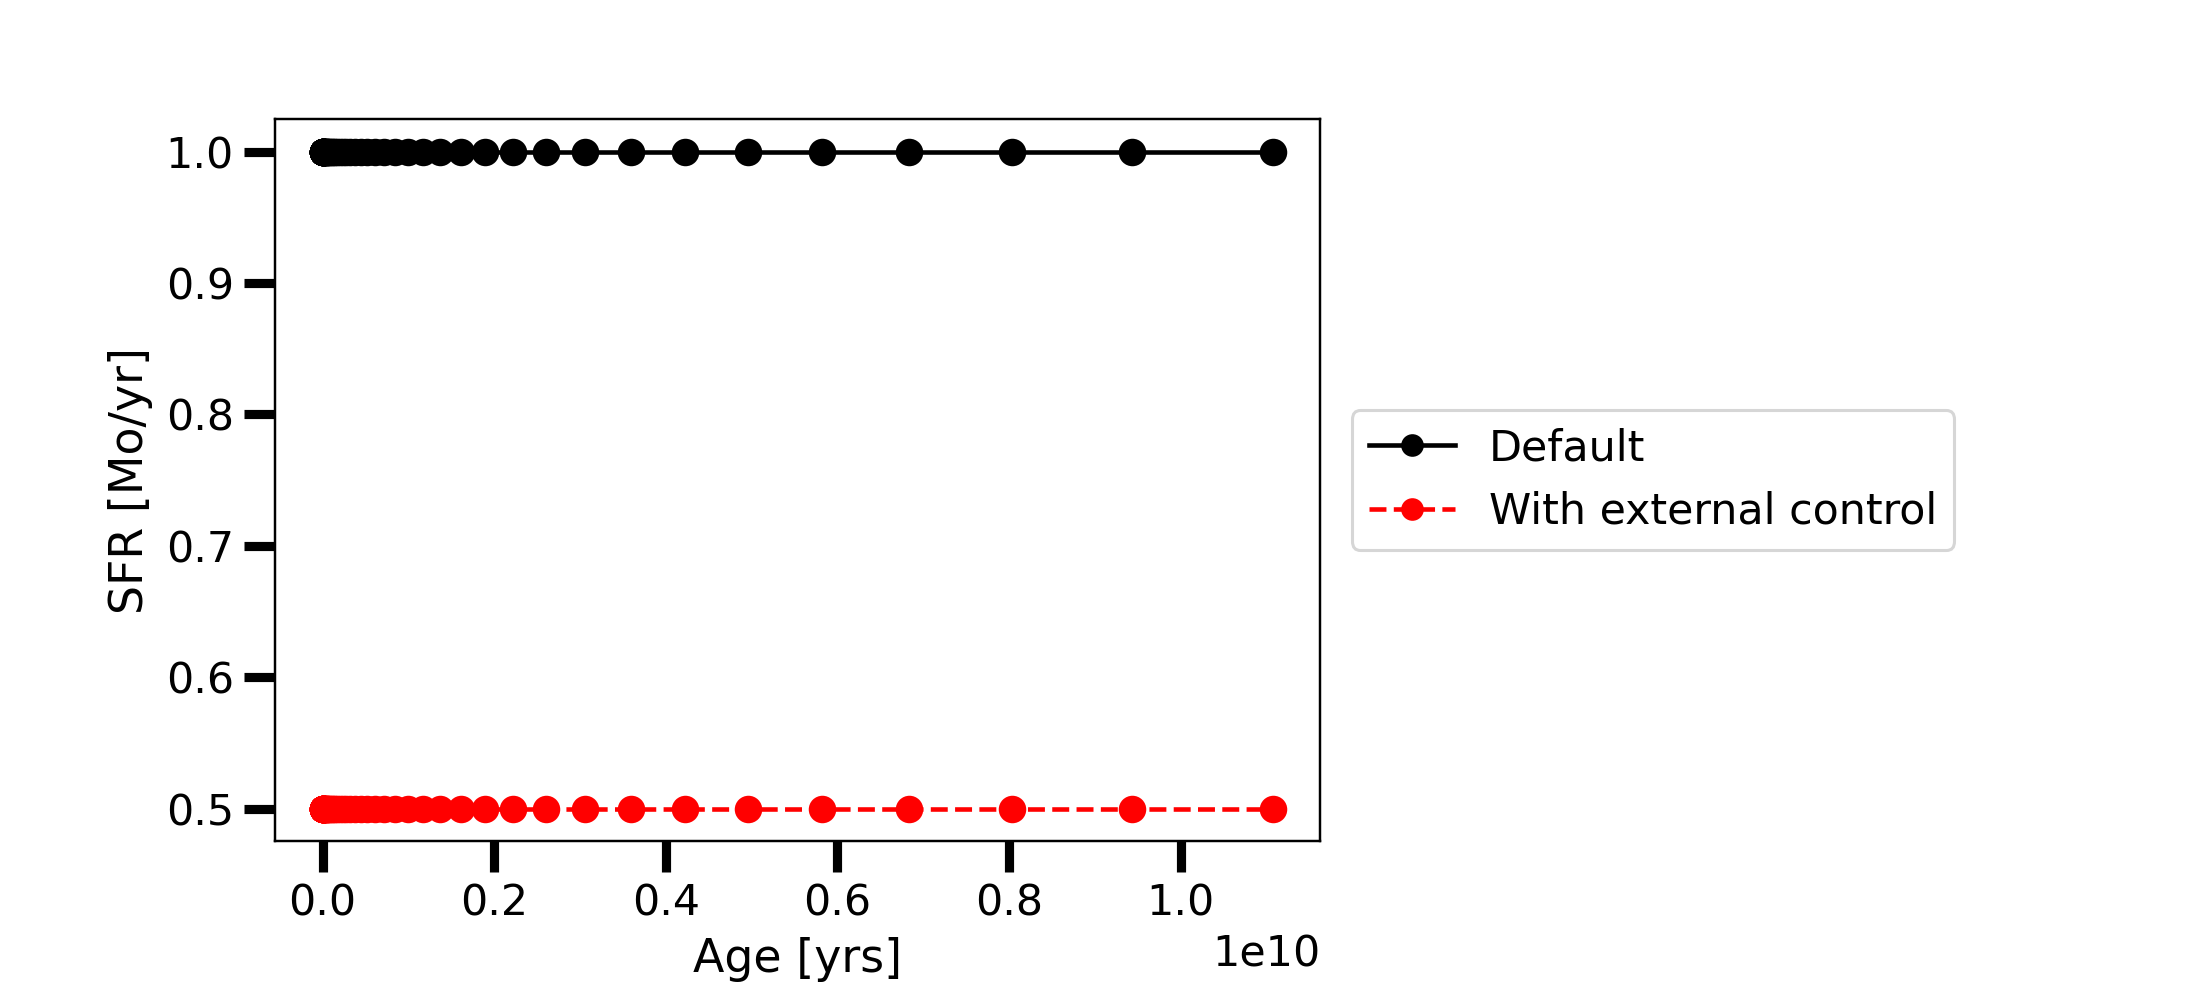

In [7]:
# Plot the different star formation histories
%matplotlib nbagg
o.plot_star_formation_rate(color='k', label='Default')
o_ext_2.plot_star_formation_rate(color='r', shape='--', label='With external control')

## 3. Removing Gas by Hand

In [8]:
# Start OMEGA with external control
o_ext_3 = omega.omega(external_control=True)

# For each timestep ..
for i_t in range(o.nb_timesteps):
    
    # Copy the star formation rate of the default OMEGA
    sfr = o.history.sfr_abs[i_t]
    
    # Copy the total mass of gas currently present
    # in the halted OMEGA.
    m_gas = sum(o_ext_3.ymgal[i_t])
    
    # Run the halted OMEGA by one step, but remove 10%
    # of the gas reservoir.  This will eventually empty
    # the gas reservoir.
    o_ext_3.run_step(i_t+1, sfr, m_lost=0.02*m_gas)

OMEGA run in progress..
   OMEGA run completed - Run time: 0.36s


<IPython.core.display.Javascript object>


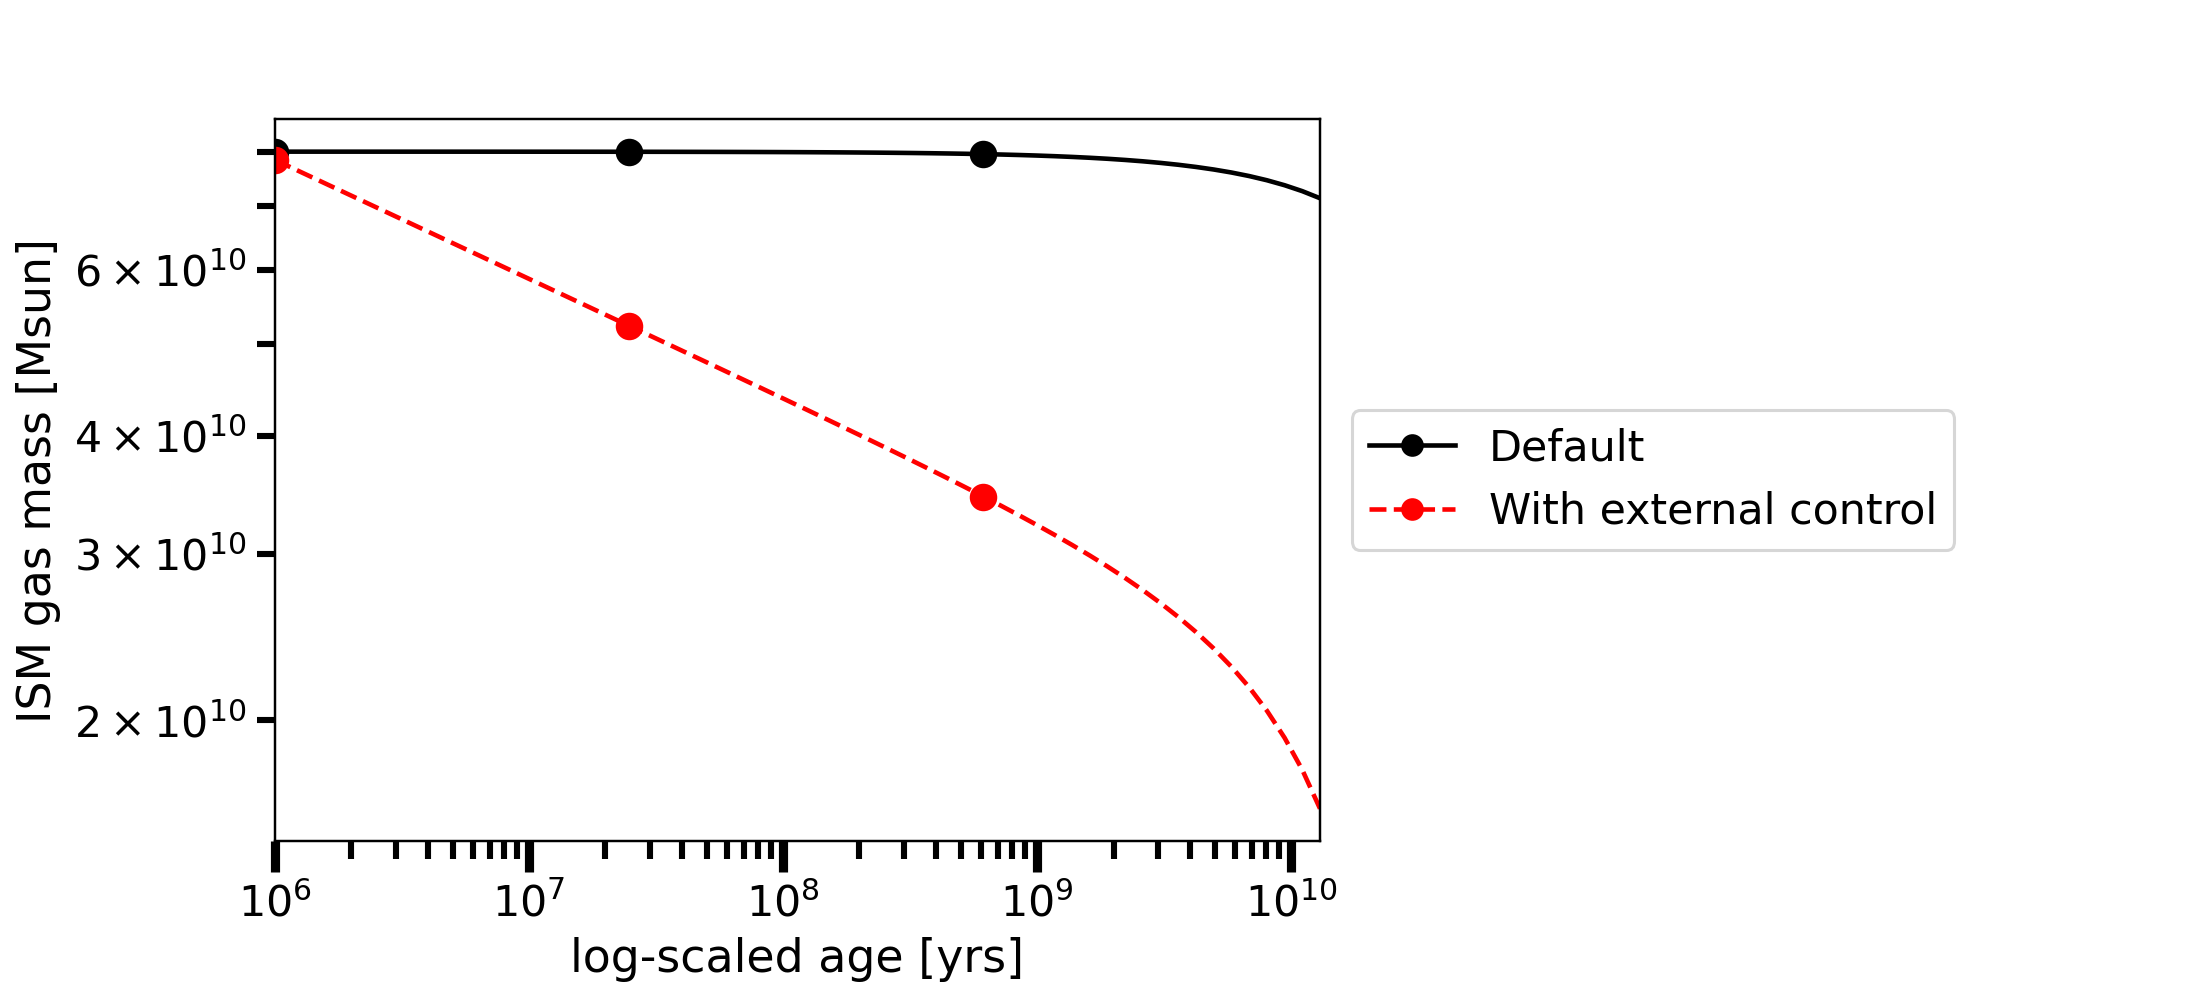

In [9]:
# Plot the different amount of gas inside the galaxy
%matplotlib nbagg
o.plot_totmasses(color='k', label='Default')
o_ext_3.plot_totmasses(color='r', shape='--', label='With external control')

## 4. Add Gas by Hand

When adding gas in OMEGA, you need to provide the chemical composition, following the same list of isotopes as in the halted OMEGA.

In [10]:
# Start OMEGA with external control
o_ext_4 = omega.omega(external_control=True)

# For each timestep ..
for i_t in range(o.nb_timesteps):
    
    # Copy the star formation rate of the default OMEGA
    sfr = o.history.sfr_abs[i_t]
    
    # Copy the mass of each isotope 'X' currently present
    # in the halted OMEGA.
    # ymgal[ timestep_index ][ isotope_index ]
    m_gas_X = o_ext_4.ymgal[i_t]
    
    # Run the halted OMEGA by one step, but add 5%
    # of the gas reservoir
    o_ext_4.run_step(i_t+1, sfr, m_added=0.05*m_gas_X)

OMEGA run in progress..
   OMEGA run completed - Run time: 0.35s


<IPython.core.display.Javascript object>


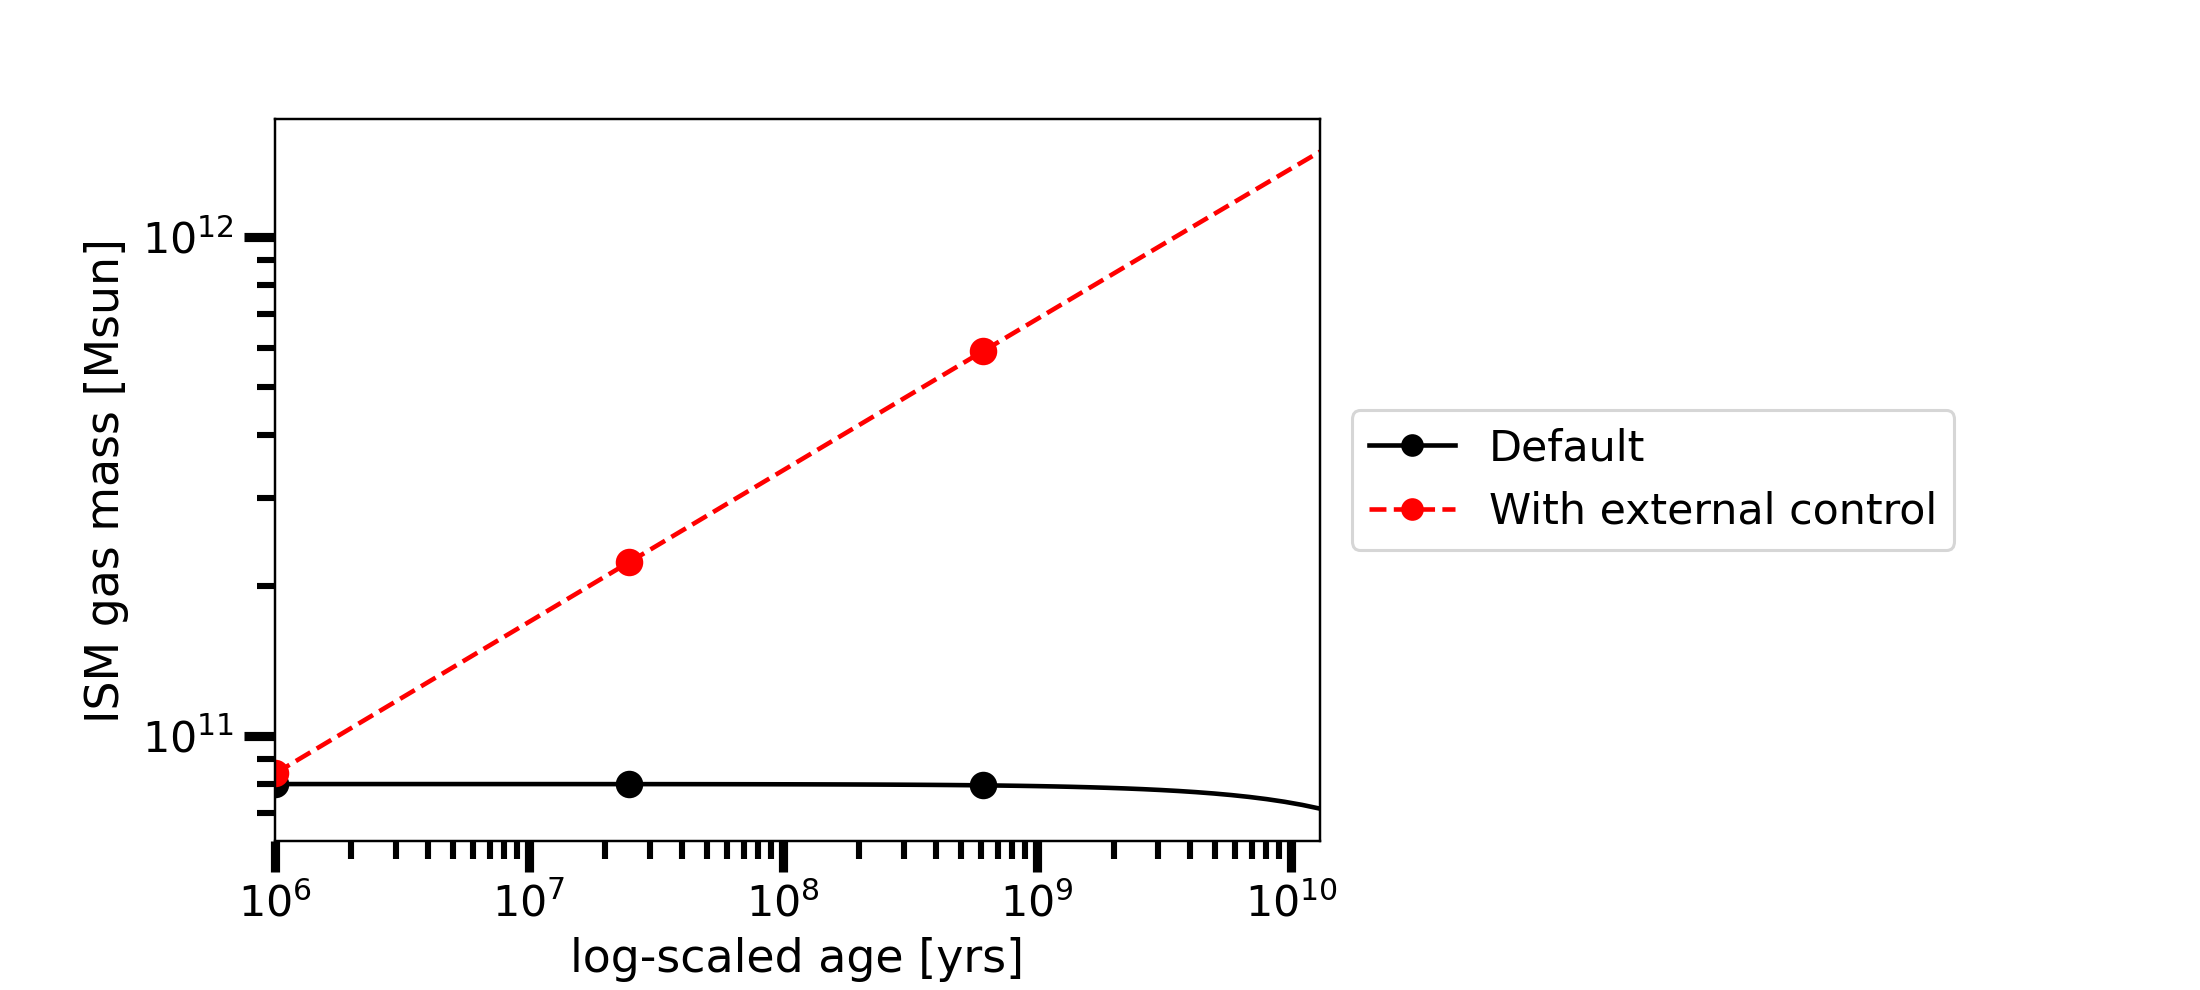

In [11]:
# Plot the different amount of gas inside the galaxy
%matplotlib nbagg
o.plot_totmasses(color='k', label='Default')
o_ext_4.plot_totmasses(color='r', shape='--', label='With external control')

It is possible to specify an arbitraty chemical composition for the added mass, as shown below.

In [12]:
# Start OMEGA with external control
o_ext_4_b = omega.omega(external_control=True)

# For each timestep ..
for i_t in range(o.nb_timesteps):
    
    # Copy the star formation rate of the default OMEGA
    sfr = o.history.sfr_abs[i_t]
    
    # Create an array with only 1e4 Msun of the Ca-40 isotope
    m_gas_X = np.zeros(o_ext_4_b.nb_isotopes)
    i_Ca_40 = o_ext_4_b.history.isotopes.index('Ca-40')
    m_gas_X[i_Ca_40] = 1.0e4
    
    # Run the halted OMEGA by one step, but add 5%
    # of the gas reservoir
    o_ext_4_b.run_step(i_t+1, sfr, m_added=m_gas_X)

OMEGA run in progress..
   OMEGA run completed - Run time: 0.4s


<IPython.core.display.Javascript object>


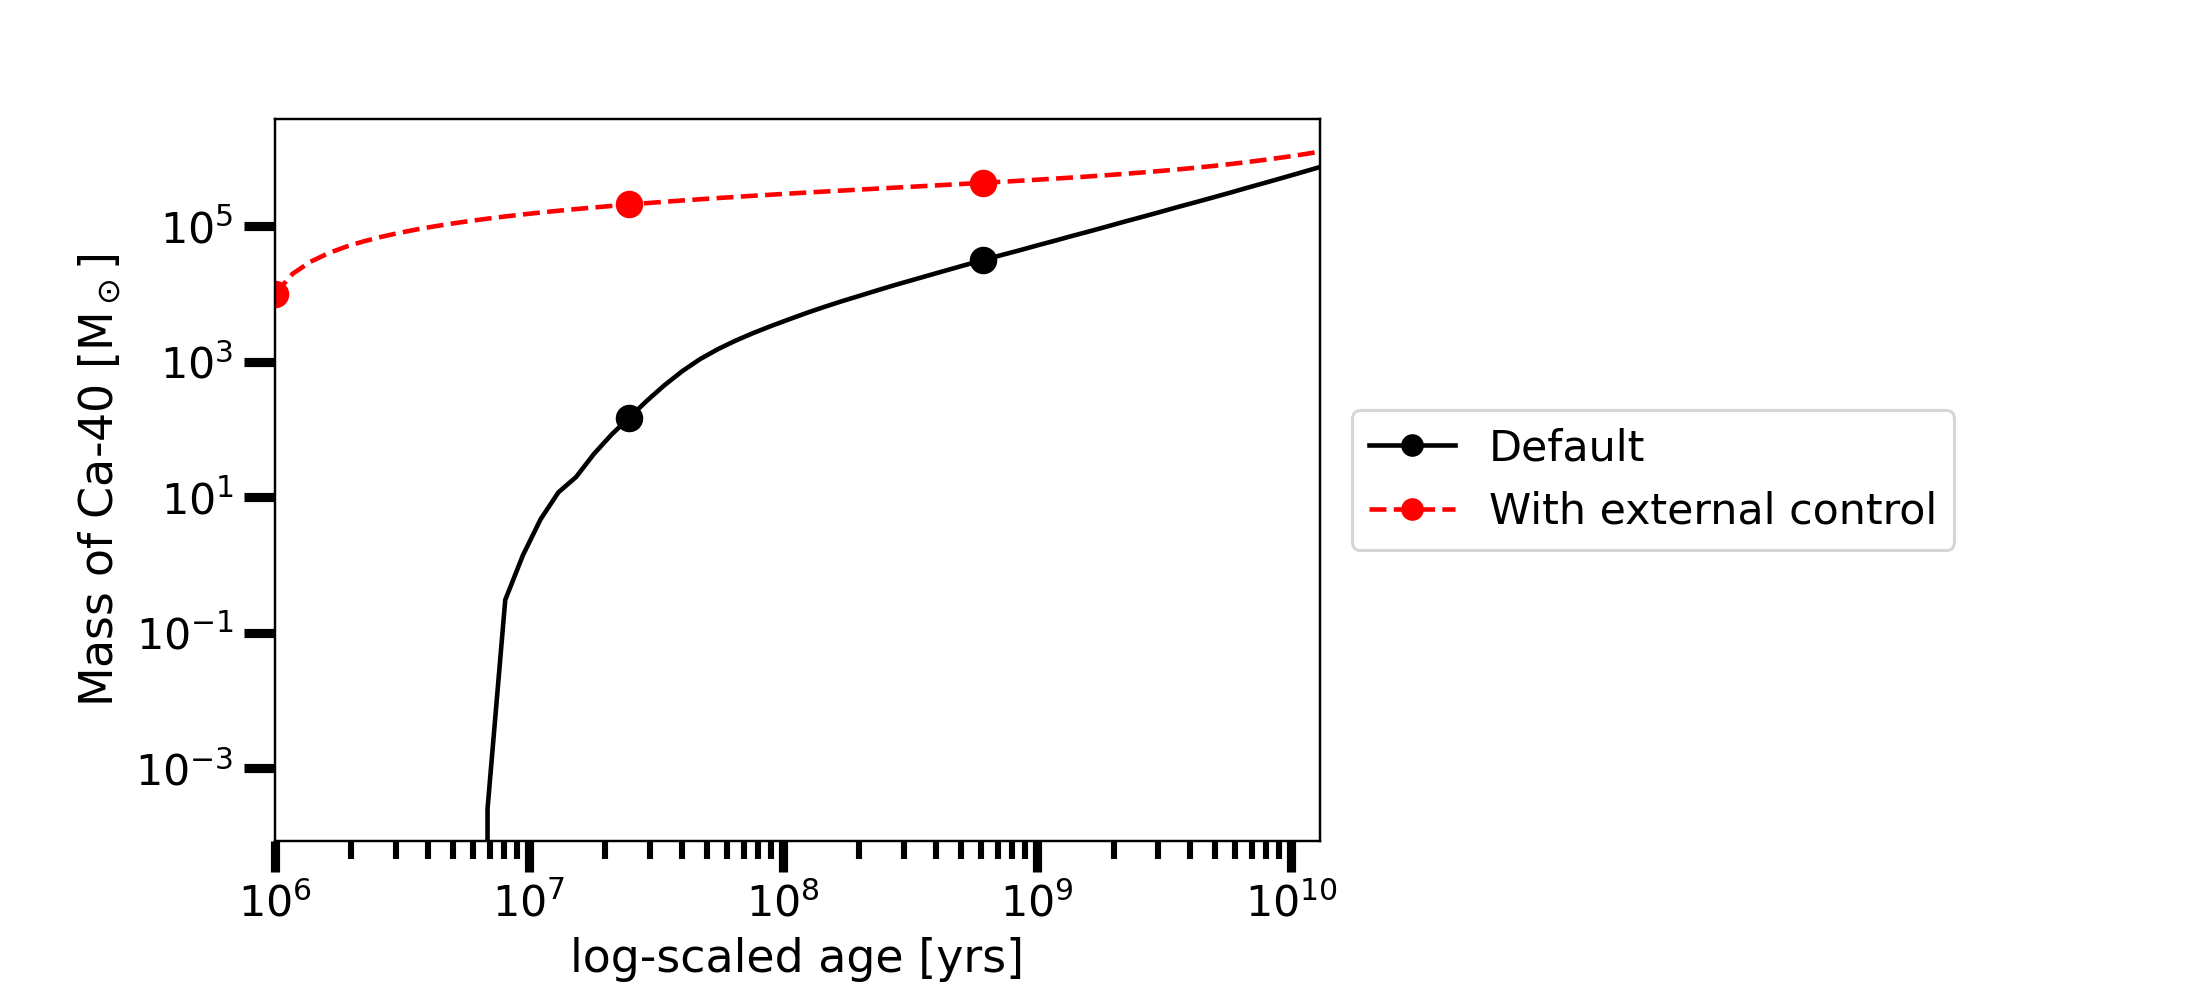

Text(0, 0.5, 'Mass of Ca-40 [M$_\\odot$]')

In [13]:
# Plot the amount of Ca-40
%matplotlib nbagg
specie = 'Ca-40'
o.plot_mass(specie=specie, color='k', label='Default')
o_ext_4_b.plot_mass(specie=specie, color='r', shape='--', label='With external control')
plt.ylabel('Mass of '+specie+' [M$_\odot$]')

<IPython.core.display.Javascript object>


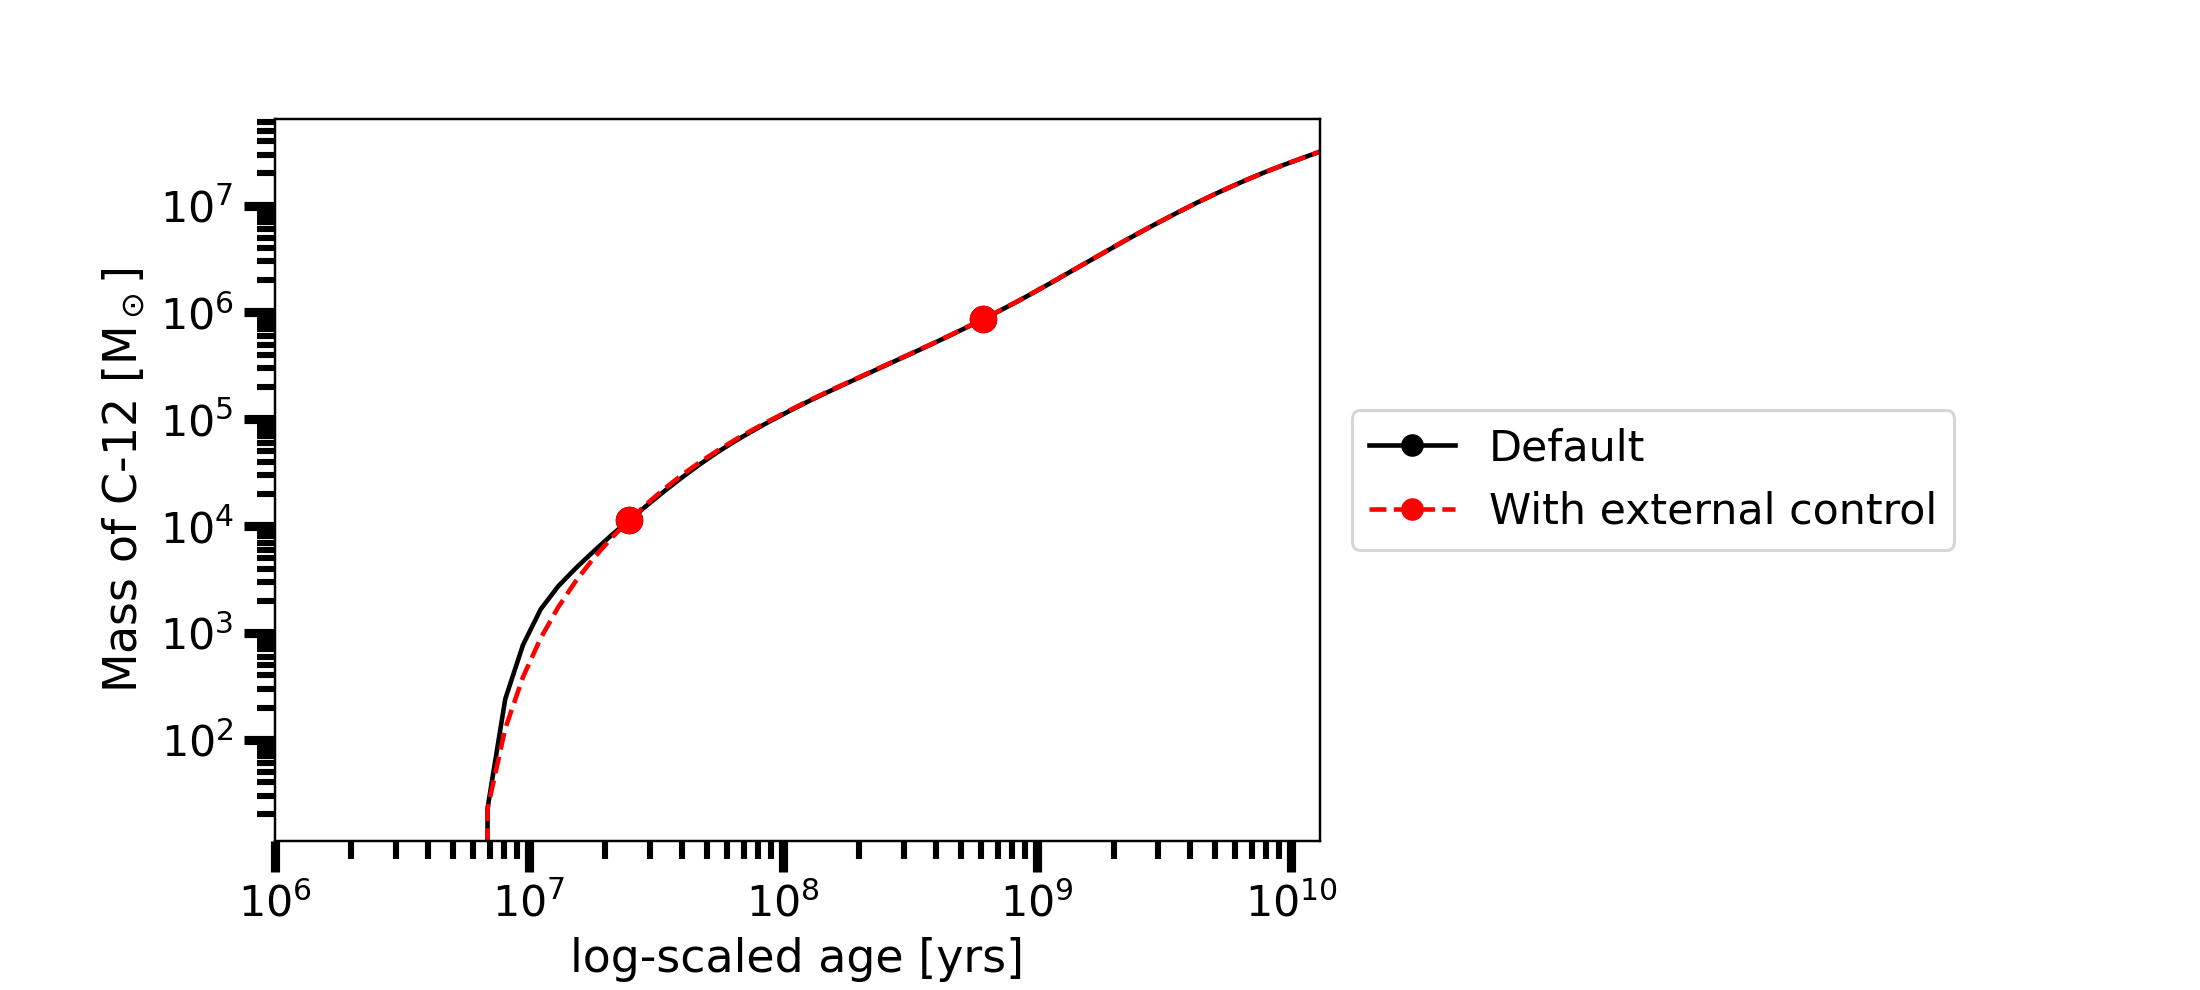

Text(0, 0.5, 'Mass of C-12 [M$_\\odot$]')

In [14]:
# Plot the amount of C-12
%matplotlib nbagg
specie = 'C-12'
o.plot_mass(specie=specie, color='k', label='Default')
o_ext_4_b.plot_mass(specie=specie, color='r', shape='--', label='With external control')
plt.ylabel('Mass of '+specie+' [M$_\odot$]')

## 5. Transfering Gas From One OMEGA to Another

The following example will form stars based on the mass of gas $M_\mathrm{gas}$ available.  The star formation rate $\dot{M}_\star$ is defined by,

$$ \dot{M}_\star = f_\star M_\mathrm{gas},$$

where $f_\star$ is the star formation efficiency, which is set to 10$^{-10}\,$yr$^{-1}$ as an example.

In [15]:
# Start OMEGA with external control
omega_1 = omega.omega(external_control=True)
omega_2 = omega.omega(external_control=True)

# Define the star formation efficiency
f_star = 1.0e-10

# For each timestep ..
for i_t in range(o.nb_timesteps):
    
    # Calculate the star formation rate of both OMEGA
    sfr_1 = f_star * sum(omega_1.ymgal[i_t])
    sfr_2 = f_star * sum(omega_2.ymgal[i_t])
    
    # Extract 2% of the gas of omega_1.
    # This is the chemical composition.
    f_m_gas_X_1 = 0.02 * omega_1.ymgal[i_t]
    
    # Calculate the total mass that will be
    # transfered to omega_2
    f_m_gas_1 = sum(f_m_gas_X_1)
    
    # Run omega_1 by removing the mass of gas that
    # will be transfered to omega_2
    omega_1.run_step(i_t+1, sfr_1, m_lost=f_m_gas_1)
    
    # Run omega_2 by adding the mass of gas (with chemical
    # composition) that is transfered from omega_2
    omega_2.run_step(i_t+1, sfr_2, m_added=f_m_gas_X_1)

OMEGA run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 1.28s
   OMEGA run completed - Run time: 0.75s


<IPython.core.display.Javascript object>


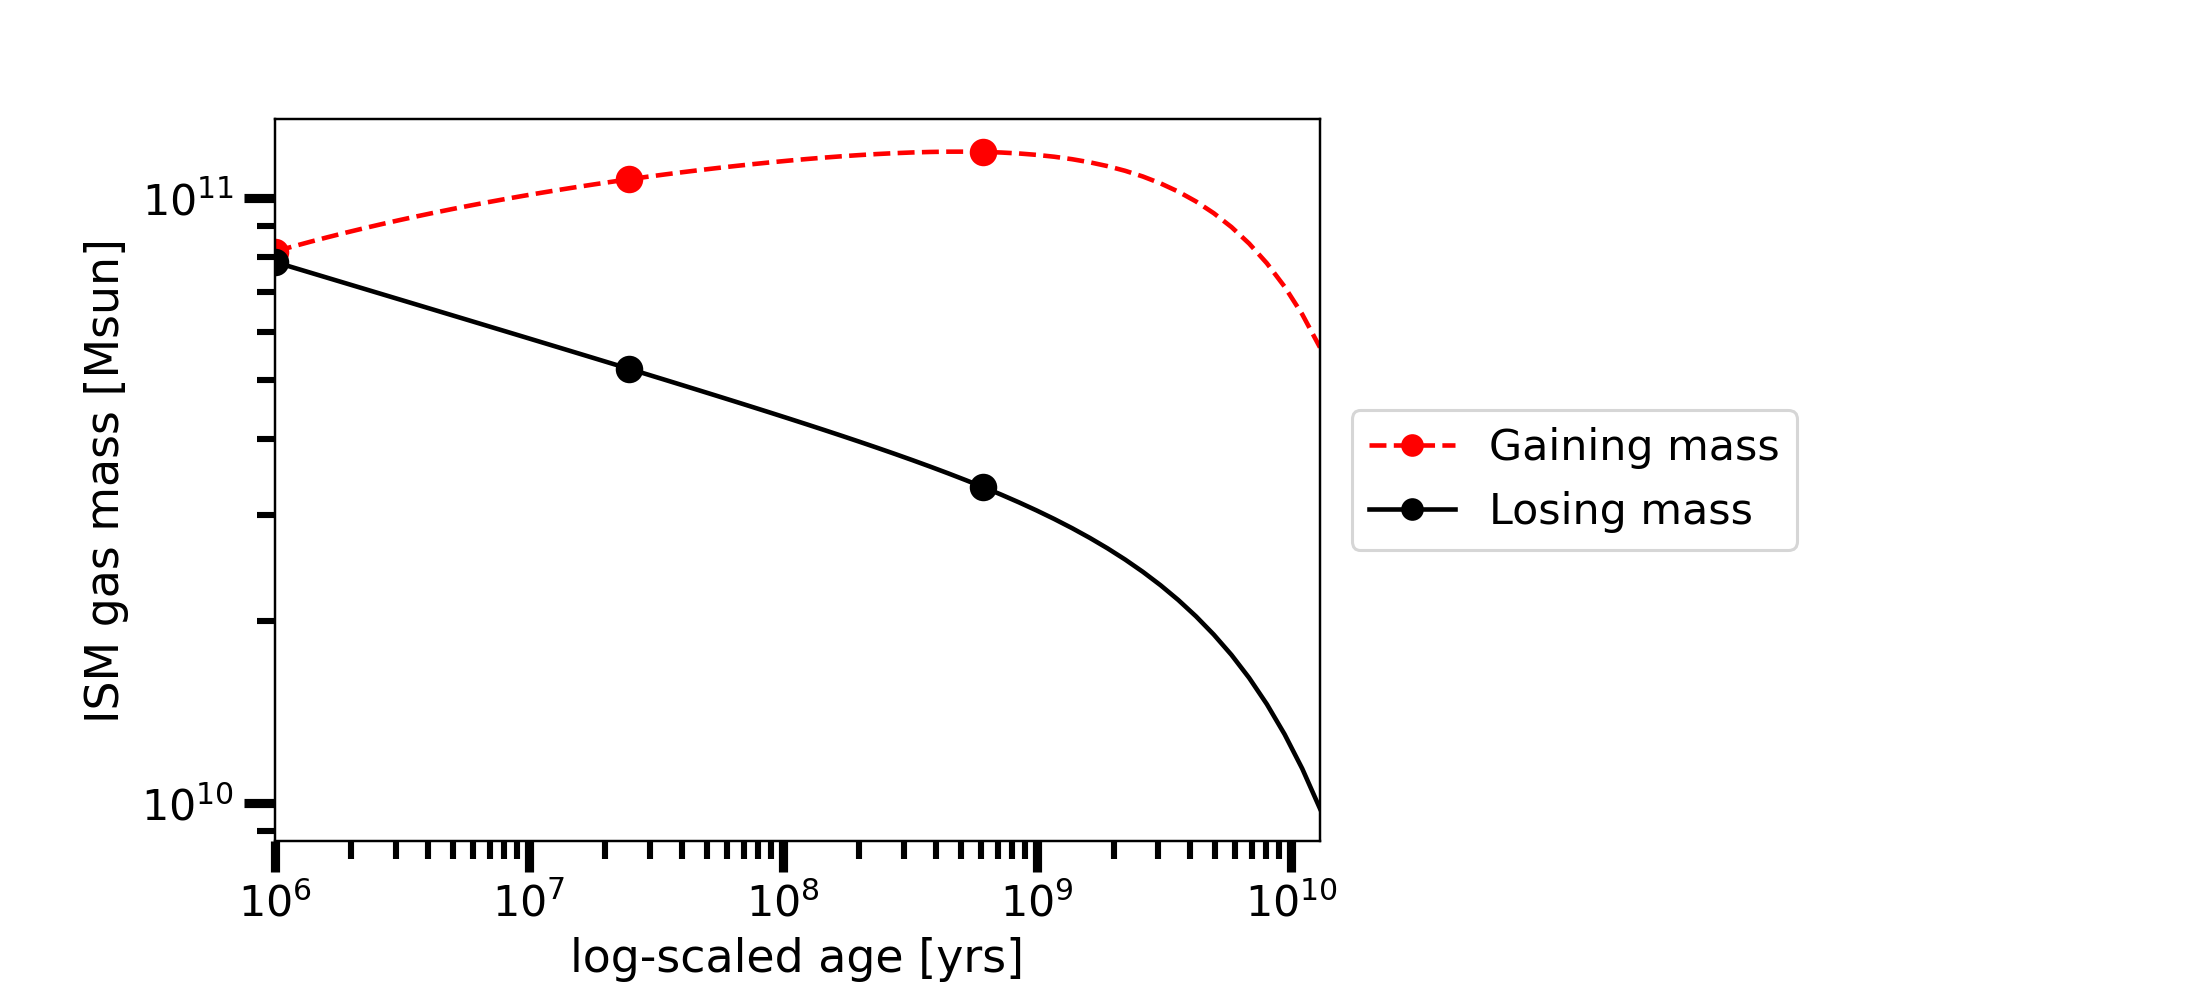

In [16]:
# Plot the different amount of gas inside both galaxies
%matplotlib nbagg
omega_2.plot_totmasses(color='r', shape='--', label='Gaining mass')
omega_1.plot_totmasses(color='k', label='Losing mass')

<IPython.core.display.Javascript object>


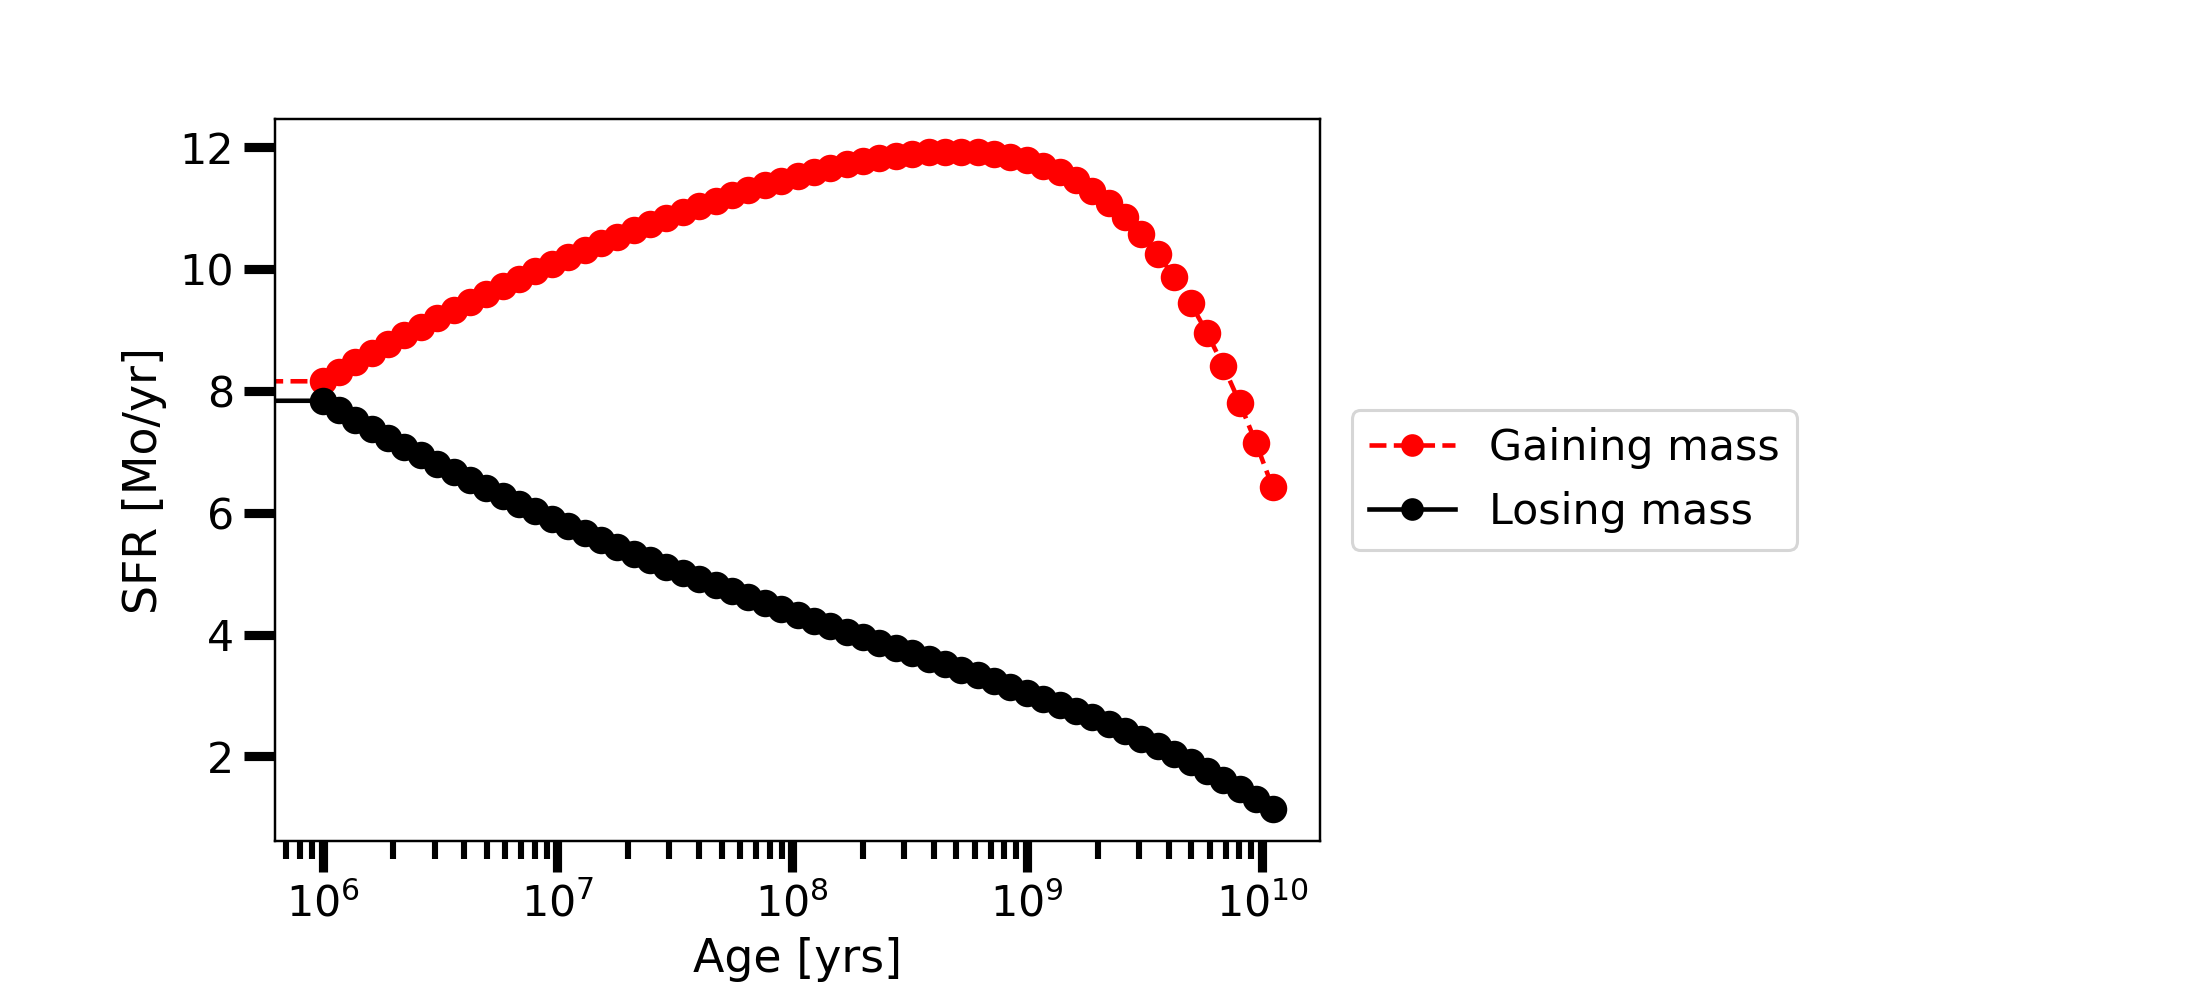

In [18]:
# Plot the star formation history of both galaxies
%matplotlib nbagg
omega_2.plot_star_formation_rate(color='r', shape='--', label='Gaining mass')
omega_1.plot_star_formation_rate(color='k', label='Losing mass')
plt.xscale('log')